# Head pose

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../DataLoader')

from Dataset import Dataset
import helpers
from helpers import imshow

from scipy.spatial.transform import Rotation as R

## Creation of a Dataset container

In [2]:
DATASET_PATH= '../Data'
dp = Dataset(path=DATASET_PATH)[0]

## Head coordinates system

World to image function definition

In [3]:
world_to_img = lambda x : helpers.world_to_img(x, dp.intrinsic_matrix, dp.extrinsic_matrix)

Let's create a rotation matrix from the head Euler angles. Our convention is: **Roll (y axis) -> Pitch (x axis) -> Yaw (z axis)** <br> 
We'll extract the head coordinates system (X, Y, Z vectors) from the matrix columns.

In [4]:
yaw, pitch, roll = dp.head_metadata.head_rotation

head_rotation_mat = R.from_euler('yxz', [roll, pitch, yaw], degrees=True).as_matrix()
head_X_world, head_Y_world, head_Z_world = head_rotation_mat.T

Let's project the axes in the image plane. <br> 
To do so, we'll define the origin of the coordinates system as the point between the eyes. <br>

In [5]:

arrow_length = 0.04
head_location_world = dp.head_metadata.head_six_dof.location
head_X_img, head_Y_img, head_Z_img = world_to_img(arrow_length * np.vstack([head_X_world, head_Y_world, head_Z_world]) + head_location_world)


We can do the same for the look-at vector.

In [6]:

look_at_cam = world_to_img(arrow_length * dp.head_metadata.head_six_dof.look_at_vector \
    + head_location_world)

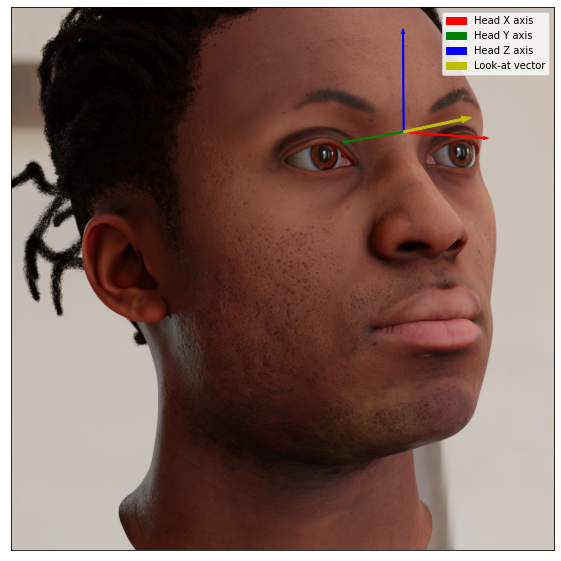

In [7]:

head_center_cam = world_to_img(head_location_world)

imshow(dp.rgb_img)
plt.arrow(*head_center_cam, *(head_X_img - head_center_cam), color = 'r', label='Head X axis', width=2)
plt.arrow(*head_center_cam, *(head_Y_img - head_center_cam),  color = 'g', label='Head Y axis', width=2)
plt.arrow(*head_center_cam, *(head_Z_img - head_center_cam),  color = 'b', label='Head Z axis', width=2)
plt.arrow(*head_center_cam, *(look_at_cam - head_center_cam),  color = 'y', label='Look-at vector', width=4)
plt.legend()